### NBA Player Efficiency Rating Exploratory Analysis

Player Efficiency Rating is statistician and ESPN analyst John Hollinger's individual player rating statistic. Similar to sabermetrics in baseball, the stat attempts to boil down nearly all of a player's hard stats into a single determining number. The formula used for calculation adds positive contributions like field goals, assists, blocks, and steals and subtracts negative ones such as turnovers and personal fouls. It's a per-minute stat, and adjusts itself for team pace so that bench players can be compared to starters and players on fastbreak teams aren't over-inflated. Each year the league average PER is always made to be 15 for cross season comparison. More info can be found here: https://en.wikipedia.org/wiki/Player_efficiency_rating

Reception of the statistic heavily varies. Many people criticize PER for having arbitrary coefficients (issue here is lack of transparency on how the formula was derived), rewarding ineffiecient shooters, and being a poor indicator of defensive ability. The goal of this analysis is to see if relationships exist between PER and other stats that would prove some validity as to being a good indicator of individual player skill. The raw data was acquired solely via scraping https://www.basketball-reference.com/. PER and other derived statistics were calculated by me. All Python scripts I used for data collection and manipulation are posted on my GitHub.

In [107]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

Let's look at the most recent season (2016-2017) and check for trends in PER.

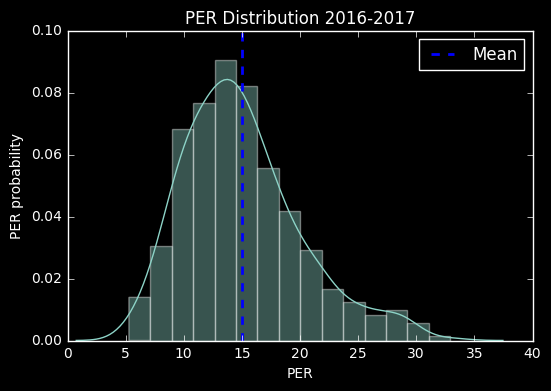

Mean: 15.002
Standard Deviation: 5.067


In [122]:
year = 2017
player_df = pd.read_csv('D:/nba_per_project/nba_PER_calculated_seasons/player_per_data_'+str(year)+'.csv')

sns.distplot(player_df['PER'],bins=15)
plt.axvline(player_df['PER'].mean(), color='b', linestyle='dashed', linewidth=2,label='Mean')
plt.ylabel('PER probability')
plt.title('PER Distribution 2016-2017')
plt.legend()
plt.show()
print('Mean:',round(player_df['PER'].mean(),3))
print('Standard Deviation:',round(player_df['PER'].std(),3))

The x-axis is PER and the y-axis represents the probability a player will fall into the respective range of PER. As expected, the league mean PER is 15. NOTE: This data isn't exactly normally distributed because of the restrictions placed on minimum minutes played. Hollinger's PER only takes into account players who have played more than 500 minutes for consistency. My data includes players who have played above 300 minutes. Had the data included all players who stepped on the court there would be a few players falling in the 0-5 range, resulting in a more normal distribution. Below is the distribution split into positions.

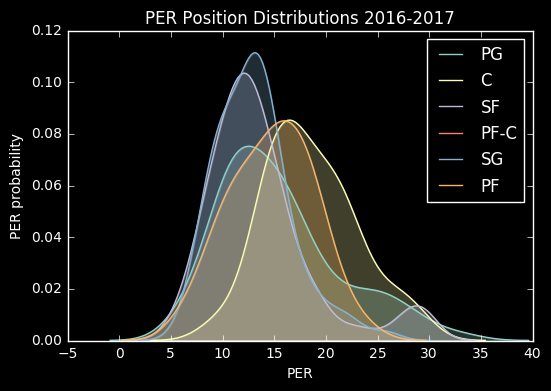

In [99]:
plt.ylim(0,.12)
for position in set(player_df.pos):
    sns.kdeplot(player_df[player_df.pos==position]['PER'],shade=True,label=position)
plt.xlabel('PER')
plt.ylabel('PER probability')
plt.title('PER Position Distributions 2016-2017')
plt.show()

In terms of PER, it looks like power forwards and centers have consistently higher numbers than other positions, while point guards are the most volatile. The small forward distribution post 25 PER looks odd. The power forward - center distribution doesn't appear because there is only one player in the league with that label. 

In [141]:
player_df[player_df.pos=='SF'][player_df.PER > 20].sort(['PER'],ascending=False).loc[:,['player', 'team_id', 'pts', 'PER']]

,player,team_id,pts,PER
102,Kevin Durant,GSW,1555,29.654670
213,Kawhi Leonard,SAS,1888,29.570793
179,LeBron James,CLE,1954,28.987976
14,Giannis Antetokounmpo,MIL,1832,27.995326
56,Jimmy Butler,CHI,1816,27.034347
152,Gordon Hayward,UTA,1601,23.732432
126,Paul George,IND,1775,21.676402


The small forward hump exceeding 25 PER looks justified. KD, Kawhi, LeBron, and Butler have all been top players for a few years. Giannis had a break out season this year.

It's difficult to validate PER strictly from a statistical standpoint, but one method we could certainly use would be to quickly compare who the NBA thinks are top players with the list of top PER performers. In 2017 the MVP finalists were Russell Westbrook (winner), James Harden, and Kawhi Leonard. Let's look at the top 6 players for PER.

In [124]:
player_df.sort(['PER'],ascending=False)[:6].loc[:,['player', 'team_id', 'pos', 'pts', 'PER']]

,player,team_id,pos,pts,PER
369,Russell Westbrook,OKC,PG,2558,32.923638
102,Kevin Durant,GSW,SF,1555,29.654670
213,Kawhi Leonard,SAS,SF,1888,29.570793
85,Anthony Davis,NOP,C,2099,29.483584
143,James Harden,HOU,PG,2356,29.379531
179,LeBron James,CLE,SF,1954,28.987976


All three MVP candidates ended up with top 5 PERs, with the MVP winner sitting comfortably ahead of everone else. This might seem obvious, but it does show that stats play a big role in candidate selection. One of the pitfalls of PER which even Hollinger admits to is it being a poor showing of defensive ability. The 2017 defensive player of the year candidates were Draymond Green (winner), Rudy Gobert, and Kawhi Leonard.

In [134]:
player_df.sort(['PER'],ascending=False).loc[:,['player', 'team_id', 'pos', 'pts', 'PER', 'fga']][player_df['player'].isin(['Draymond Green', 'Rudy Gobert', 'Kawhi Leonard'])]

,player,team_id,pos,pts,PER,fga
213,Kawhi Leonard,SAS,SF,1888,29.570793,1312
129,Rudy Gobert,UTA,C,1137,25.049218,625
136,Draymond Green,GSW,PF,776,17.730256,650


Draymond's PER is just above the league average. If PER was a decent indicator of defensive ability, we'd probably expect it to higher. Another explanation for the above results is that Draymond doesn't need to take a lot of shots because of the depth in offensive talent on the Warriors, thus because of PERs innate bias toward volume shooting he has a low PER. 

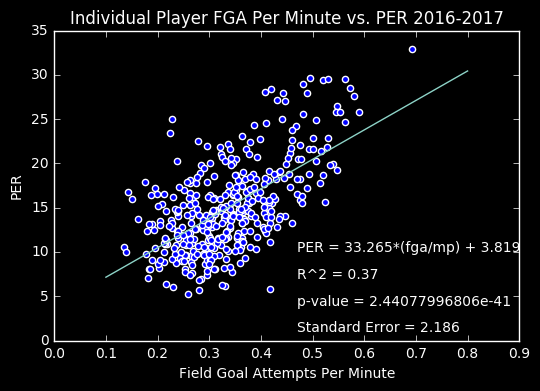

Draymond expected PER based on FGA = 12.569
Difference = 5.16093768254


In [179]:
m, b, r, p, stderr = stats.linregress(player_df['fga']/player_df['mp'],player_df['PER'])
fig, ax = plt.subplots()

ax.scatter(player_df['fga']/player_df['mp'],player_df['PER'])
ax.plot(np.linspace(.1,.8),m*np.linspace(.1,.8)+b)
ax.text(.47,7,'R^2 = '+str(round(r**2,2)))
ax.text(.47,4,'p-value = '+str(p))
ax.text(.47,10,'PER = '+str(round(m,3))+'*(fga/mp) + '+str(round(b,3)))
ax.text(.47,1,'Standard Error = '+str(round(stderr,3)))

plt.ylabel('PER')
plt.xlabel('Field Goal Attempts Per Minute')
plt.title('Individual Player FGA Per Minute vs. PER 2016-2017')
plt.show()

exp_per = m*player_df[player_df.player == 'Draymond Green']['fga'].iloc[0]/player_df[player_df.player == 'Draymond Green']['mp'].iloc[0]+b
print('Draymond expected PER based on FGA/Mp = ' + str(round(exp_per,3)))
print('Difference =',player_df[player_df.player == 'Draymond Green']['PER'].iloc[0]-exp_per)

Above is a quick graph of field goal attempts plotted against PER showing a slight linear trend with 37% of variance in PER explained just from knowing a player's number of field goal attempts per minute after performing a linear regression. A linear trend in fga per minute and PER is slightly concerning and is one of the common criticisms of PER. The formula rewards shots made much more than it penalizes shots missed, as this plot shows. It does appear that Draymond's low PER might be the result of a low shot count despite a lot of playing time, although he does significantly outperform what his expected PER should be based on field goal attempts per minute (more than doubling the standard error). You could say this is somewhat of a measure of player efficiency. Let's find the players with the furthest deviation from expected PER based on fga per minute. 

In [197]:
def calc_dev(fga,mp,per):
    return per - (m*(fga/mp) + b)

dev_list = []    
for i in range(len(player_df)):
    dev_list.append(calc_dev(player_df['fga'][i],player_df['mp'][i],player_df['PER'][i]))
    
player_df['PER_efficiency'] = pd.Series(dev_list, index=player_df.index)
player_df.sort(['PER_efficiency'],ascending=False)[:8].loc[:,['player', 'team_id', 'pos', 'PER', 'PER_efficiency', 'fga', 'mp']]

,player,team_id,pos,PER,PER_efficiency,fga,mp
129,Rudy Gobert,UTA,C,25.049218,13.653539,625,2744
195,DeAndre Jordan,LAC,C,23.466991,12.179624,577,2570
287,Chris Paul,LAC,PG,28.106595,10.694257,785,1921
190,Nikola Jokic,DEN,C,28.341335,10.583145,854,2038
14,Giannis Antetokounmpo,MIL,SF,27.995326,9.455663,1259,2845
170,Dwight Howard,ATL,C,22.473204,9.381240,613,2199
102,Kevin Durant,GSW,SF,29.654670,9.347934,1026,2070
179,LeBron James,CLE,SF,28.987976,9.167618,1344,2794


Here's a reiteration of what "PER_efficiency" is: a linear regression was performed to model the relationship between field goal attempts per minute and PER. The model shows what a player's expected PER is based solely on his field goals per minute. "PER_efficiency" is the difference between a players actual PER and what the model predicts it should be. The intuition here is that we are trying to negate the effect high volume shooting has on PER to find efficient players. The results above reinforce players we already know are good, so let's look at players who aren't big stars (here I just used players who played under 800 minutes).

In [198]:
player_df[player_df.mp < 800].sort(['PER_efficiency'],ascending=False)[:10].loc[:,['player', 'team_id', 'pos', 'PER', 'PER_efficiency', 'fga', 'fg_pct', 'mp']]

,player,team_id,pos,PER,PER_efficiency,fga,fg_pct,mp
240,JaVale McGee,GSW,C,27.124758,8.946562,319,0.652,739
381,Jeff Withey,UTA,C,20.250719,8.500562,103,0.534,432
28,Brandon Bass,LAC,PF,21.111962,6.569855,186,0.575,577
382,Brandan Wright,MEM,PF,20.024951,6.159569,135,0.615,447
229,Ian Mahinmi,WAS,C,15.221807,4.749881,111,0.586,555
374,Alan Williams,PHO,C,21.085989,4.722247,267,0.517,708
5,Cole Aldrich,MIN,C,13.721955,4.515469,86,0.523,531
105,Joel Embiid,PHI,C,25.854303,3.879358,429,0.466,786
383,Delon Wright,TOR,PG,16.126479,3.655681,116,0.422,446
158,Roy Hibbert,CHO/DEN,C,14.579752,3.590807,147,0.544,682


Ian Mahinmi, Cole Aldrich, Delon Wright, and Roy Hibbert all have unimpressive PERs, but have significantly high PER efficiencies. It's a possibility these players are undervalued, although I've never heard of either of them so I'm unable to make fair judgment.

I went ahead and precalculated all teams average PERs. Below is a graph of team average PER plotted against their win/loss percentages with a line of fit plotted in the center.

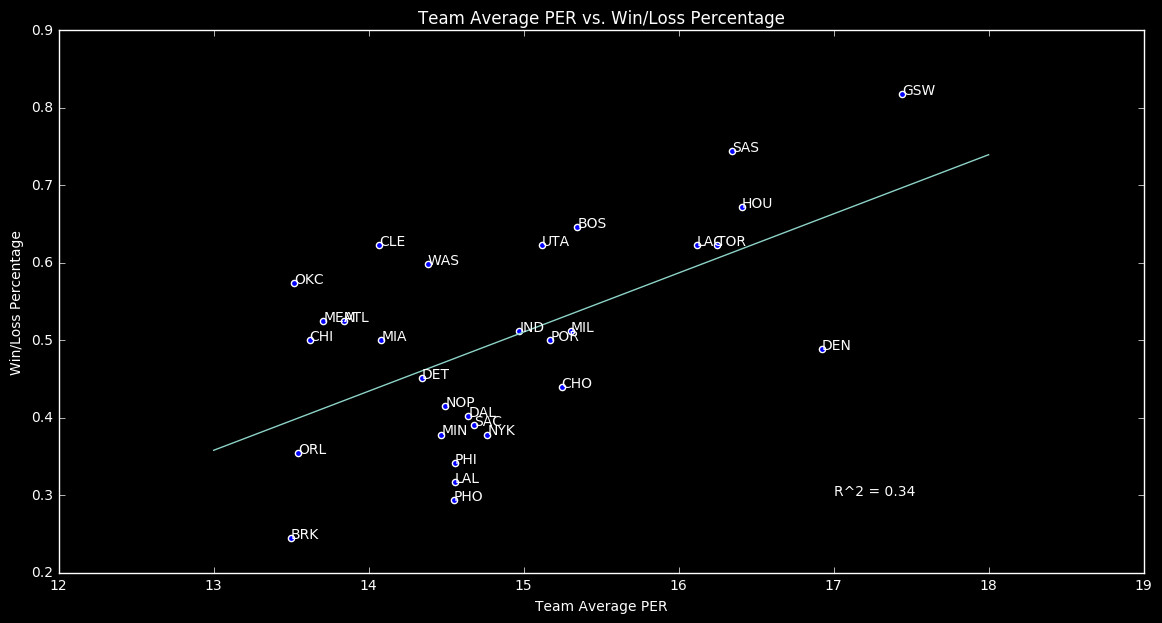

In [177]:
team_df = pd.read_csv('D:/nba_per_project/team_data/team_data_'+str(year)+'.csv')

x = list(team_df['mean_PER'])
y = list(team_df['win_loss_pct'])
teams = list(team_df['team'])

m, b, r, p, stderr = stats.linregress(x,y)

fig, ax = plt.subplots(figsize=(14, 7))
plt.scatter(x, y)
plt.plot(range(13,19),m*range(13,19)+b)
plt.text(17,.3,'R^2 = '+str(round(r**2,2)))

for i, text in enumerate(teams):
    plt.annotate(text, (x[i],y[i]))

plt.title('Team Average PER vs. Win/Loss Percentage 2016-2017')
plt.xlabel('Team Average PER')
plt.ylabel('Win/Loss Percentage')
plt.show()

Generally, team average PER should correlate with how deep a team's bench is in addition to their starters. Teams with a high average PER should in theory have better non starting players than teams with low average PERs. The Golden State Warriors have the highest average, and did indeed have excellent bench players this season, while teams like OKC Thunder and Clevelend (CLE) Cavaliers lacked good bench players despite having two of the best players in the league in Russell Westbrook and LeBron James. Teams above the line of fit are essentially "outperforming" what their average PER says their win rate should be. This could be for a variety of reasons including possibly having a great coach or good team chemistry. For example, the San Antonio Spurs (SAS) have one of the highest positive deviations away from their expected win/loss percentage and their coach, Greg Popovich, won Coach of the Year. It could also be worth noting that the team with the best players according to PER, the Warriors, had their general manager, Bob Meyers, win NBA Basketball Executive of the Year. Teams falling below the line of fit are underperforming based on their PER values. Brooklyn may want to consider restructuring their organization. 

Below is a comparison of four top teams' PER distributions.

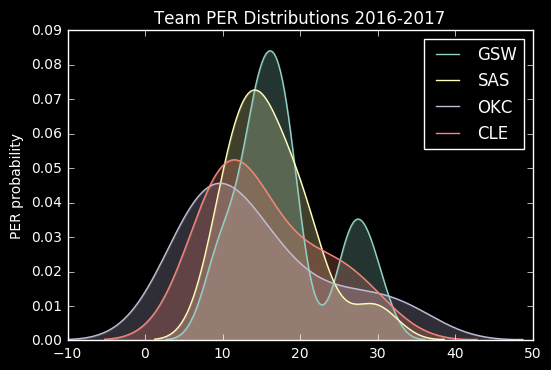

In [210]:
sns.kdeplot(player_df[player_df.team_id=='GSW']['PER'],shade=True,label='GSW')
sns.kdeplot(player_df[player_df.team_id=='SAS']['PER'],shade=True,label='SAS')
sns.kdeplot(player_df[player_df.team_id=='OKC']['PER'],shade=True,label='OKC')
sns.kdeplot(player_df[player_df.team_id=='CLE']['PER'],shade=True,label='CLE')

plt.ylabel('PER probability')
plt.title('Team PER Distributions 2016-2017')
plt.legend()
plt.show()

Looking at where the PER range probability is peaking for each team is where most of the bench players reside, and it looks like the hypothesis that higher team average PER insinuates bench players with higher PERs was correct.

Here's the linear regression for team average PER and win/loss percentage for all teams in the 1980-2017 seasons.

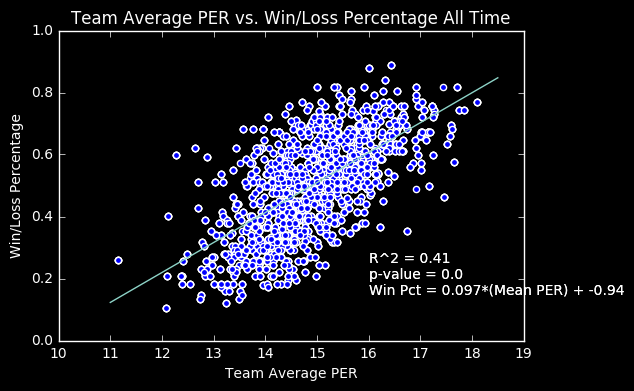

In [229]:
for year in range(2016,1980,-1):
    df = pd.read_csv('D:/nba_per_project/team_data/team_data_'+str(year)+'.csv')
    team_df = pd.concat([team_df,df])
    
x = list(team_df['mean_PER'])
y = list(team_df['win_loss_pct'])
teams = list(team_df['team'])

m, b, r, p, stderr = stats.linregress(x,y)


plt.scatter(x, y)
plt.plot(np.linspace(11,18.5),m*np.linspace(11,18.5)+b)
plt.title('Team Average PER vs. Win/Loss Percentage Seasons 1980-2017')
plt.xlabel('Team Average PER')
plt.ylabel('Win/Loss Percentage')
plt.text(16,.25,'R^2 = '+str(round(r**2,2)))
plt.text(16,.2,'p-value = '+str(p))
plt.text(16,.15,'Win Pct = '+str(round(m,3))+'*(Mean PER) + '+str(round(b,3)))
plt.show()

The p-value is significantly low, therefore we can conclude there is a relationship between team average PER and win/loss percentage. A coefficient of determination of .41 means we can explain 41% of the variance in win/loss percentage just from knowing team average PER. The model predicts that for every 1 unit increase in team average PER, win/loss percentage should increase by about 9.7%; a pretty significant increase. Theoretically, a team with 0 average PER would have a -.94, which doesn't make sense, but neither does having a team average PER of 0.

### Conclusions

The purpose of this analysis was to determine the usefulness of the PER statistic. In my eyes, the stat is useful if it shows patterns in line with what we already know about players, and if we can explain the inconsistencies. Understanding the limitations of the stat is crucial. In the case of Draymond, the NBA recognizes him as one of the best defensive players in the league but PER doesn't reflect that. Understanding PER rewards volume shooting helped show Draymond actually has significantly higher PER than he should based on how much he shoots.

The team average PER vs. win/loss percentage model shows there is definitely a correlation between PER and win rate. The teams that deviate from their predicted values are certainly explainable.

PER is not an end-all stat, but it definitely carries some clout could be worth utilizing to find undervalued players.